In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import sys
sys.path.insert(0, '../')
import pandas as pd
import talib as ta
import numpy as np
from config import key_id, secret_key
from datetime import datetime 
from scipy import signal
import scipy
from pandas import DataFrame

In [2]:
#use modin for faster processing
#import modin.pandas as pd

In [3]:
data=pd.read_csv('data/JACK.csv')

In [4]:
type(data.index[0])

int

In [5]:
data2=data.set_index('timestamp').sort_index(ascending=False)

# Cleaning data


In [6]:
#converting timestamp row to timestamp type
data2.index=pd.to_datetime(data2.index, utc=True)

In [7]:
# Create a DatetimeIndex and assign it to the dataframe.
data2.index = pd.DatetimeIndex(data2.index)

In [8]:
#Count ticks on unique days
day_tick_cnt = data2.index.normalize() \
                     .value_counts() \
                     .to_frame().reset_index()

#Keep days that have ticks greater than 300
day_list=day_tick_cnt[~(day_tick_cnt['timestamp'] >= 240)]

In [9]:
len(day_tick_cnt)- len(day_list)

2690

In [10]:
#create date
data2['date']=data2.index.date

In [11]:
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [12]:
#if date is in data, keep the data
cond= data2['date'].isin(day_list['index'])
data2.drop(data2[cond].index, inplace = True)

In [13]:
#data should now be cleaned of days where data is spotty
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [14]:
#create time frame of opening to one hour before closing/ after hours
#data=pd.DataFrame.between_time(data,"14:30","20:00")

# Create Features
## Adding indicators

In [15]:
import talib.abstract as tab

In [16]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #make sure to remove these later
        #exponential moving averages
        dataframe['sema_high'] = tab.EMA(dataframe, timeperiod=12, price='high')
        dataframe['fema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        dataframe['dema'] = ta.DEMA(dataframe['close'], timeperiod=30)
        
        #mathematics
        
        macd=tab.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
        #dataframe['macd'] = macd['macd']
        dataframe['macdsignal']=macd['macdsignal']
        dataframe['macdhist']=macd['macdhist']
        
        
        #stochastics
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        stoch= tab.STOCH(dataframe, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        stoch_rsi=tab.STOCHRSI(dataframe, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        
        
        #dataframe['slowd'] = stoch['slowd']
        #dataframe['slowk'] = stoch['slowk']
        
        dataframe['fastdf'] = stoch_fast['fastd']
        dataframe['fastkf'] = stoch_fast['fastk']
        
        dataframe['fastdrsi'] = stoch_rsi['fastd']
        dataframe['fastkrsi'] = stoch_rsi['fastk']
        
        #momentum indicators
        #dataframe['willr'] = tab.WILLR(dataframe['high'].values, dataframe['low'].values, dataframe['close'].values)
        dataframe['ultosc'] = tab.ULTOSC(dataframe)
        
        
        dataframe['mfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=14)
        #dataframe['smfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=20)
        #dataframe['fmfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=8)
        
        dataframe['adx'] = tab.ADX(dataframe)
        #dataframe['fadx'] = tab.ADX(dataframe, timeperiod=8)
        #dataframe['sadx'] = tab.ADX(dataframe, timeperiod=20)
        
        dataframe['adxr'] = tab.ADXR(dataframe)
        
        #dataframe['adxr'] = tab.ADXR(dataframe)
        
        dataframe['cci'] = tab.CCI(dataframe)
        dataframe['rsi2'] = tab.RSI(dataframe, timeperiod=14)
        dataframe['rocr'] =tab.ROCR(dataframe)
        
        
        dataframe['plus_di'] =tab.PLUS_DI(dataframe)
        dataframe['minus_di'] =tab.MINUS_DI(dataframe)
        dataframe['mom']=tab.MOM(dataframe)
        
        #statistics 
        #dataframe['sbeta']=tab.BETA(dataframe, timeperiod=9)
        dataframe['beta']=tab.BETA(dataframe, timeperiod=5)
        #dataframe['fbeta']=tab.BETA(dataframe, timeperiod=3)
        
        #dataframe['scorrel']=tab.CORREL(dataframe, timeperiod=30)
        dataframe['correl']=tab.CORREL(dataframe, timeperiod=17)
        #dataframe['fcorrel']=tab.CORREL(dataframe, timeperiod=10)
        
        #dataframe['svar']=tab.VAR(dataframe, timeperiod=8)
        dataframe['var']=tab.VAR(dataframe, timeperiod=5)
        #dataframe['fvar']=tab.VAR(dataframe, timeperiod=3)
        #dataframe['linearreg']=tab.LINEARREG(dataframe, timeperiod=10)
        dataframe['linearreg_angle']=tab.LINEARREG_ANGLE(dataframe, timeperiod=10)
        dataframe['linear_slope']=tab.LINEARREG_SLOPE(dataframe, timeperiod=10)
        #dataframe['tsf']=tab.TSF(dataframe, timeperiod=14)
        #create time indicators
        #dataframe['months']=dataframe.index.get_level_values(level='timestamp').month
        #dataframe['dayofweek']=dataframe.index.get_level_values(level='timestamp').dayofweek
        #dataframe['hourofday']=dataframe.index.get_level_values(level='timestamp').hour
        
        
        # required for graphing
        bollinger =ta.BBANDS(dataframe.close,timeperiod=5,nbdevup=1.7, nbdevdn=1.7)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]
        
        #create volume based indicators
        dataframe['adosc']=ta.ADOSC(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))
        #dataframe['ad']=ta.AD(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))
        #dataframe['obv']=ta.OBV(dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))
        #Create volatility indicator
        dataframe['natr'] = tab.NATR(dataframe)
        
        #create row of labels/classification
        #if dataframe
            #dataframe['maxindex'] = tab.MAXINDEX(dataframe, timeperiod=30)
        
        
        
        
        return dataframe

In [17]:
#tab.MINUS_DI(data3)[0:50]

In [18]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [19]:


def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band



In [20]:
data3=data2.sort_index(ascending=True)

In [21]:
data3.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15


In [22]:
# Compute RSI
#rsi_df = get_rsi(data3, window=14)
#data3['rsi'] = pd.Series(data=rsi_df.values, index=data3.index)





In [23]:
data3.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15


In [24]:
# compute bands
#window = 50
#data3['avg'], data3['upper'], data3['lower'] = bbands(data3['close'], window, no_of_stdev=1.5)
#data3.sample(10)

In [25]:
data3=populateindicators(data3)
# Drop the NaN values from our data set
data3

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,beta,correl,var,linearreg_angle,linear_slope,bb_lowerband,bb_upperband,bb_middleband,adosc,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,NaN,20.552980,20.552980,20.552980,...,NaN,NaN,0.130779,NaN,NaN,19.938204,21.167756,20.55298,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 16:20:00+00:00,46.9300,46.9300,46.8100,46.8100,1410,2020-04-09,46.840367,46.858997,46.787209,46.742941,...,0.092879,0.250694,0.002160,-0.027467,-0.000479,46.700991,46.859009,46.78000,-308.037626,0.367663
2020-04-09 16:21:00+00:00,46.9200,46.9200,46.8232,46.8232,763,2020-04-09,46.852618,46.879331,46.799206,46.769694,...,-0.234710,0.161133,0.002213,-0.472141,-0.008241,46.700671,46.860609,46.78064,-873.687811,0.358085
2020-04-09 16:22:00+00:00,46.8900,46.9000,46.7500,46.8700,3005,2020-04-09,46.859908,46.886221,46.822804,46.763129,...,0.518602,0.348178,0.003536,-0.126919,-0.002215,46.695546,46.897734,46.79664,-451.982177,0.355035


In [26]:
data4=data3.dropna()

In [27]:
data4

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,beta,correl,var,linearreg_angle,linear_slope,bb_lowerband,bb_upperband,bb_middleband,adosc,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.820,19.8000,19.8000,750,2008-12-15,19.920079,19.850298,19.830240,19.822830,...,1.714041e-01,0.982369,0.001376,-1.569165,-0.027394,19.764939,19.891061,19.82800,-2370.348311,0.228589
2008-12-15 15:40:00+00:00,19.820,19.820,19.8000,19.8100,2500,2008-12-15,19.904682,19.840198,19.823494,19.815220,...,3.205105e-02,0.982880,0.000080,-1.289805,-0.022515,19.794795,19.825205,19.81000,-2159.909661,0.219365
2008-12-15 15:41:00+00:00,19.800,19.820,19.8000,19.8050,1600,2008-12-15,19.891654,19.833466,19.817329,19.810147,...,1.697933e-01,0.982868,0.000056,-0.666684,-0.011636,19.794278,19.819722,19.80700,-2132.011154,0.210961
2008-12-15 15:42:00+00:00,19.805,19.810,19.8000,19.8000,2600,2008-12-15,19.879092,19.825644,19.811553,19.806764,...,1.539215e-12,0.981916,0.000056,-0.440995,-0.007697,19.794278,19.819722,19.80700,-2754.051659,0.199549
2008-12-15 15:43:00+00:00,19.810,19.810,19.8000,19.8100,1000,2008-12-15,19.868463,19.820429,19.811035,19.804510,...,2.312706e-12,0.980411,0.000020,-0.437523,-0.007636,19.797397,19.812603,19.80500,-2439.972624,0.188808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09,46.840367,46.858997,46.787209,46.742941,...,9.287883e-02,0.250694,0.002160,-0.027467,-0.000479,46.700991,46.859009,46.78000,-308.037626,0.367663
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09,46.852618,46.879331,46.799206,46.769694,...,-2.347105e-01,0.161133,0.002213,-0.472141,-0.008241,46.700671,46.860609,46.78064,-873.687811,0.358085
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09,46.859908,46.886221,46.822804,46.763129,...,5.186024e-01,0.348178,0.003536,-0.126919,-0.002215,46.695546,46.897734,46.79664,-451.982177,0.355035


# Machine Learning Setup

In [28]:
import mlfinlab as ml
import timeit


from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)




Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

# Triple Barrier labelling


In [29]:
#Read in data
data_ml=data4

In [30]:
data4.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'sema_high',
       'fema_high', 'ema_close', 'ema_low', 'dema', 'macdsignal', 'macdhist',
       'fastdf', 'fastkf', 'fastdrsi', 'fastkrsi', 'ultosc', 'mfi', 'adx',
       'adxr', 'cci', 'rsi2', 'rocr', 'plus_di', 'minus_di', 'mom', 'beta',
       'correl', 'var', 'linearreg_angle', 'linear_slope', 'bb_lowerband',
       'bb_upperband', 'bb_middleband', 'adosc', 'natr'],
      dtype='object')

In [31]:
data4[['fema_high','ultosc','rocr','cci','mfi','beta','adx','adxr','macdsignal','cci','rsi2','natr','adosc','correl','mom','plus_di','minus_di']][40:80]
#'linearreg',

,fema_high,ultosc,rocr,cci,mfi,beta,adx,adxr,macdsignal,cci,rsi2,natr,adosc,correl,mom,plus_di,minus_di
timestamp,,,,,,,,,,,,,,,,,
2008-12-15 16:20:00+00:00,19.340345,45.905528,0.990760,-86.093874,34.765038,4.236399,57.469291,56.400762,-0.102311,-86.093874,32.950584,0.331188,-2998.403241,0.890071,-0.1800,6.978526,49.994842
2008-12-15 16:21:00+00:00,19.386896,37.367445,0.992802,-23.414072,52.908842,0.453725,55.443957,54.479754,-0.102716,-23.414072,34.209086,0.373955,-5141.962719,0.854858,-0.1400,22.558556,41.089417
2008-12-15 16:22:00+00:00,19.364598,34.515714,0.994333,-69.388803,48.055817,0.226398,53.646672,52.941802,-0.102379,-69.388803,33.531298,0.358527,-5699.907106,0.842516,-0.1100,21.859670,40.849126
2008-12-15 16:23:00+00:00,19.346398,35.342685,0.994333,-58.489891,49.343153,0.006025,51.977764,51.513703,-0.101361,-58.489891,33.531298,0.336619,-5960.438255,0.823227,-0.1100,21.619234,40.399824
2008-12-15 16:24:00+00:00,19.334266,36.893723,0.993818,-55.353535,49.858230,0.040723,50.521393,50.432947,-0.099899,-55.353535,32.778106,0.320142,-5811.524793,0.811738,-0.1200,21.118921,40.621992
2008-12-15 16:25:00+00:00,19.322844,34.678256,0.995356,-50.966495,49.869773,0.027094,49.169048,49.661248,-0.098008,-50.966495,32.778106,0.300978,-5476.830668,0.771251,-0.0900,20.858995,40.122028
2008-12-15 16:26:00+00:00,19.313562,22.969728,0.995614,-43.252841,51.430925,0.060070,47.913300,48.944670,-0.095643,-43.252841,33.642447,0.281258,-4682.925738,0.725776,-0.0850,20.721668,39.857880
2008-12-15 16:27:00+00:00,19.305708,27.525332,0.998187,-71.565495,51.985253,-2.142964,47.259231,48.723506,-0.093206,-71.565495,31.876839,0.281821,-3817.880472,0.687264,-0.0350,19.222498,43.551331
2008-12-15 16:28:00+00:00,19.297139,31.590053,1.002606,-92.498431,55.092727,-1.571152,46.651881,48.723840,-0.091198,-92.498431,29.007753,0.277017,-3371.463730,0.636534,0.0500,18.191682,41.215869


### Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).


In [32]:
data_ml.head()

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,beta,correl,var,linearreg_angle,linear_slope,bb_lowerband,bb_upperband,bb_middleband,adosc,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.82,19.8,19.800,750,2008-12-15,19.920079,19.850298,19.830240,19.822830,...,1.714041e-01,0.982369,0.001376,-1.569165,-0.027394,19.764939,19.891061,19.828,-2370.348311,0.228589
2008-12-15 15:40:00+00:00,19.820,19.82,19.8,19.810,2500,2008-12-15,19.904682,19.840198,19.823494,19.815220,...,3.205105e-02,0.982880,0.000080,-1.289805,-0.022515,19.794795,19.825205,19.810,-2159.909661,0.219365
2008-12-15 15:41:00+00:00,19.800,19.82,19.8,19.805,1600,2008-12-15,19.891654,19.833466,19.817329,19.810147,...,1.697933e-01,0.982868,0.000056,-0.666684,-0.011636,19.794278,19.819722,19.807,-2132.011154,0.210961
2008-12-15 15:42:00+00:00,19.805,19.81,19.8,19.800,2600,2008-12-15,19.879092,19.825644,19.811553,19.806764,...,1.539215e-12,0.981916,0.000056,-0.440995,-0.007697,19.794278,19.819722,19.807,-2754.051659,0.199549
2008-12-15 15:43:00+00:00,19.810,19.81,19.8,19.810,1000,2008-12-15,19.868463,19.820429,19.811035,19.804510,...,2.312706e-12,0.980411,0.000020,-0.437523,-0.007636,19.797397,19.812603,19.805,-2439.972624,0.188808


## Fit a Primary Model: Bollinger Band Mean-Reversion

In [33]:
# Compute sides
#when above bb, is 1, when below is -1
data_ml['side'] = np.nan
long_signals = (data_ml['close'] <= data_ml['bb_lowerband']) 
short_signals = (data_ml['close'] >= data_ml['bb_upperband']) 

data_ml.loc[long_signals, 'side'] = 1
data_ml.loc[short_signals, 'side'] = -1

print(data_ml.side.value_counts())

# Remove Look ahead biase by lagging the signal
data_ml['side'] = data_ml['side'].shift(1)
#.shift(1)



 1.0    57422
-1.0    55880
Name: side, dtype: int64


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [34]:
# Save the raw data
raw_data = data_ml.copy()

# Drop the NaN values from our data set
data_ml.dropna(axis=0, how='any', inplace=True)

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [35]:
data_ml

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,correl,var,linearreg_angle,linear_slope,bb_lowerband,bb_upperband,bb_middleband,adosc,natr,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:46:00+00:00,19.75,19.750,19.72,19.720,800,2008-12-15,19.835536,19.791979,19.772159,19.745781,...,0.934652,0.001056,-0.348979,-0.006091,19.726757,19.837243,19.78200,-1553.559154,0.222122,1.0
2008-12-15 15:47:00+00:00,19.72,19.720,19.72,19.720,200,2008-12-15,19.817762,19.767986,19.754772,19.737187,...,0.925966,0.001504,-0.560786,-0.009788,19.700072,19.831928,19.76600,-1288.173466,0.206256,1.0
2008-12-15 16:00:00+00:00,19.59,19.700,19.59,19.700,1100,2008-12-15,19.730865,19.713753,19.704758,19.664850,...,0.574562,0.000104,-0.171192,-0.002988,19.688663,19.723337,19.70600,541.169092,0.159137,1.0
2008-12-15 16:02:00+00:00,19.46,19.460,19.46,19.460,200,2008-12-15,19.673459,19.606112,19.564337,19.546600,...,0.813388,0.015080,-1.529954,-0.026709,19.391239,19.808761,19.60000,96.660212,0.234866,1.0
2008-12-15 16:18:00+00:00,19.31,19.320,19.09,19.190,3238,2008-12-15,19.439321,19.383276,19.310998,19.270018,...,0.832081,0.006264,-1.503235,-0.026242,19.199453,19.468547,19.33400,-2327.113342,0.333574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 15:48:00+00:00,46.61,46.630,46.61,46.620,1042,2020-04-09,46.568893,46.618298,46.520502,46.438634,...,0.577265,0.012856,0.222237,0.003879,46.295247,46.680753,46.48800,79.603268,0.518261,-1.0
2020-04-09 16:05:00+00:00,46.78,46.780,46.68,46.680,583,2020-04-09,46.849657,46.909109,46.783499,46.750949,...,0.790488,0.020056,0.427106,0.007455,46.607247,47.088753,46.84800,-1617.827726,0.401546,1.0
2020-04-09 16:09:00+00:00,46.84,46.840,46.54,46.830,3111,2020-04-09,46.846575,46.857602,46.799580,46.674509,...,0.759901,0.004880,-1.225595,-0.021394,46.641243,46.878757,46.76000,-1460.075492,0.399645,-1.0


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [36]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data_ml['close'], lookback=50)


In [37]:
daily_vol

timestamp
2008-12-16 15:48:00+00:00         NaN
2008-12-16 15:49:00+00:00    0.000717
2008-12-16 15:52:00+00:00    0.002124
2008-12-16 16:01:00+00:00    0.003234
2008-12-16 16:05:00+00:00    0.010133
                               ...   
2020-04-09 15:48:00+00:00    0.045717
2020-04-09 16:05:00+00:00    0.045152
2020-04-09 16:09:00+00:00    0.044669
2020-04-09 16:19:00+00:00    0.044143
2020-04-09 16:24:00+00:00    0.043876
Name: close, Length: 113257, dtype: float64

In [38]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data_ml['close'], threshold=daily_vol['2009-01-01':'2020-01-01'].mean() * 0.15)

In [39]:
# Compute vertical barrier, gives the timestamps of when vertical barriers are crossed
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data_ml['close'], num_days=1)

In [40]:
vertical_barriers.head()

2008-12-15 16:02:00+00:00   2008-12-16 16:05:00+00:00
2008-12-15 16:18:00+00:00   2008-12-16 16:23:00+00:00
2008-12-15 16:19:00+00:00   2008-12-16 16:23:00+00:00
2008-12-15 16:28:00+00:00   2008-12-16 16:34:00+00:00
2008-12-15 16:47:00+00:00   2008-12-16 16:50:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [41]:
#ptsl=profit taking and/or stop loss
pt_sl = [1, 1]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data_ml['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=5,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data_ml['side'])

2020-05-21 12:06:01.854242 100.0% apply_pt_sl_on_t1 done after 0.45 minutes. Remaining 0.0 minutes.


In [42]:
labels = ml.labeling.get_bins(triple_barrier_events, data_ml['close'])
labels.side.value_counts()

 1.0    26059
-1.0    25676
Name: side, dtype: int64

In [43]:
labels

,ret,trgt,bin,side
2008-12-16 15:52:00+00:00,-0.006436,0.002124,0,-1.0
2008-12-16 16:01:00+00:00,-0.004455,0.003234,0,-1.0
2008-12-16 16:05:00+00:00,-0.012225,0.010133,0,-1.0
2008-12-16 16:23:00+00:00,-0.014563,0.014152,0,-1.0
2008-12-16 16:27:00+00:00,-0.016393,0.016374,0,-1.0
...,...,...,...,...
2020-04-07 19:29:00+00:00,-0.117149,0.053947,0,-1.0
2020-04-07 19:40:00+00:00,-0.110802,0.052657,0,-1.0
2020-04-07 19:46:00+00:00,-0.107461,0.051841,0,-1.0
2020-04-07 19:56:00+00:00,-0.104343,0.051118,0,-1.0


## Results of Primary Model:

In [44]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     32927
           1       0.36      1.00      0.53     18808

    accuracy                           0.36     51735
   macro avg       0.18      0.50      0.27     51735
weighted avg       0.13      0.36      0.19     51735

Confusion Matrix
[[    0 32927]
 [    0 18808]]

Accuracy
0.36354498888566733


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 ###  Meta-labeling says that there aremany false-positives (50%) the sklearn's confusion matrix is [[TN, FP][FN, TP]]. however,  50% accuracy for a non metamodel is pretty good



# Fit a Meta Model

### Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

### Create the following features:
   - Volatility
   - Serial Correlation
   - The returns at the different lags from the serial correlation
   - The sides from the SMavg Strategy


In [45]:
raw_data.head()

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,correl,var,linearreg_angle,linear_slope,bb_lowerband,bb_upperband,bb_middleband,adosc,natr,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.82,19.8,19.800,750,2008-12-15,19.920079,19.850298,19.830240,19.822830,...,0.982369,0.001376,-1.569165,-0.027394,19.764939,19.891061,19.828,-2370.348311,0.228589,NaN
2008-12-15 15:40:00+00:00,19.820,19.82,19.8,19.810,2500,2008-12-15,19.904682,19.840198,19.823494,19.815220,...,0.982880,0.000080,-1.289805,-0.022515,19.794795,19.825205,19.810,-2159.909661,0.219365,NaN
2008-12-15 15:41:00+00:00,19.800,19.82,19.8,19.805,1600,2008-12-15,19.891654,19.833466,19.817329,19.810147,...,0.982868,0.000056,-0.666684,-0.011636,19.794278,19.819722,19.807,-2132.011154,0.210961,NaN
2008-12-15 15:42:00+00:00,19.805,19.81,19.8,19.800,2600,2008-12-15,19.879092,19.825644,19.811553,19.806764,...,0.981916,0.000056,-0.440995,-0.007697,19.794278,19.819722,19.807,-2754.051659,0.199549,NaN
2008-12-15 15:43:00+00:00,19.810,19.81,19.8,19.810,1000,2008-12-15,19.868463,19.820429,19.811035,19.804510,...,0.980411,0.000020,-0.437523,-0.007636,19.797397,19.812603,19.805,-2439.972624,0.188808,NaN


In [46]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
#raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
#raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
#raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
#raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
#raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

#raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
#raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
#raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
#raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
#raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
#raw_data['log_t1'] = raw_data['log_ret'].shift(1)
#raw_data['log_t2'] = raw_data['log_ret'].shift(2)
#raw_data['log_t3'] = raw_data['log_ret'].shift(3)
#raw_data['log_t4'] = raw_data['log_ret'].shift(4)
#raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

In [47]:
# Add Trending signals
raw_data['sma'] = 0

long_signals = raw_data['fema_high'] >= raw_data['sema_high']
short_signals = raw_data['fema_high'] < raw_data['sema_high']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [48]:
# Re compute sides
raw_data['side'] = 0

long_signals = raw_data['close'] <= raw_data['fema_high'] 
short_signals = raw_data['close'] >= raw_data['ema_low'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [49]:
# Remove look ahead bias .shift(1)
raw_data_shifted = raw_data

In [50]:
raw_data_shifted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'sema_high',
       'fema_high', 'ema_close', 'ema_low', 'dema', 'macdsignal', 'macdhist',
       'fastdf', 'fastkf', 'fastdrsi', 'fastkrsi', 'ultosc', 'mfi', 'adx',
       'adxr', 'cci', 'rsi2', 'rocr', 'plus_di', 'minus_di', 'mom', 'beta',
       'correl', 'var', 'linearreg_angle', 'linear_slope', 'bb_lowerband',
       'bb_upperband', 'bb_middleband', 'adosc', 'natr', 'side', 'log_ret',
       'volatility', 'fast_mavg', 'slow_mavg', 'sma'],
      dtype='object')

In [51]:
#make sure to drop all
# Get features at event dates
X = raw_data_shifted.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low' ,'close','volume','date','fema_high','sema_high','ema_low','ema_close', 'dema',   'close',  \
        'bb_lowerband', 'bb_upperband', 'bb_middleband', 'fast_mavg', 'slow_mavg','volatility','sma'], axis=1, inplace=True)
#'macd','macdsignal','macdhist',
#,'months','dayofweek','hourofday'
y = labels['bin'].dropna()
X

,macdsignal,macdhist,fastdf,fastkf,fastdrsi,fastkrsi,ultosc,mfi,adx,adxr,...,beta,correl,var,linearreg_angle,linear_slope,adosc,natr,side,log_ret,sma
2008-12-16 15:52:00+00:00,-0.001292,0.006429,87.179487,61.538462,86.011382,58.034147,56.766000,25.796641,22.192550,21.304447,...,-0.024684,0.667521,0.002144,0.362695,0.006330,200.718563,0.182186,-1,-0.002488,1
2008-12-16 16:01:00+00:00,-0.002015,0.005454,68.333333,95.000000,99.055126,100.000000,60.469923,28.679284,19.997438,21.210681,...,0.814520,0.715631,0.002336,-0.145843,-0.002545,60.008304,0.210243,-1,0.002988,1
2008-12-16 16:05:00+00:00,0.010527,0.019475,93.939394,100.000000,93.424043,100.000000,63.893816,33.760404,17.047899,19.935343,...,0.253155,0.883697,0.002904,1.440772,0.025152,183.528801,0.229608,-1,0.000000,1
2008-12-16 16:23:00+00:00,0.037123,0.005457,94.444444,100.000000,100.000000,100.000000,80.415412,82.471799,14.276691,14.008427,...,-0.192220,0.737245,0.002208,0.718937,0.012548,3636.511473,0.137250,-1,0.000419,1
2008-12-16 16:27:00+00:00,0.050372,0.016598,98.245614,100.000000,100.000000,100.000000,87.872069,87.746401,23.937452,17.641630,...,-0.555872,0.954207,0.001504,1.502715,0.026233,3614.507167,0.141802,-1,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-07 19:29:00+00:00,-0.037872,0.030499,80.746547,62.765957,86.681879,60.045636,58.658390,43.212350,13.707973,12.463996,...,0.247127,0.814470,0.109097,3.231177,0.056455,1124.889972,0.634094,-1,-0.008791,1
2020-04-07 19:40:00+00:00,0.035051,0.052401,86.837607,94.166667,94.038770,82.116310,77.990361,68.586543,20.045915,15.820992,...,-0.059746,0.808170,0.014670,3.043464,0.053168,5496.486868,0.489243,-1,-0.000876,1
2020-04-07 19:46:00+00:00,0.104300,0.044421,80.456896,74.654062,48.575573,33.648255,64.744880,55.581765,27.218264,20.896422,...,0.424001,0.950490,0.016488,2.383587,0.041625,4931.623964,0.502431,-1,-0.003925,1
2020-04-07 19:56:00+00:00,0.159221,0.009401,70.429074,53.430079,75.559902,26.679706,48.793607,45.951482,28.376999,25.744445,...,1.005479,0.756106,0.039362,0.647415,0.011300,2221.178048,0.680905,-1,-0.008740,1


In [52]:
X.columns

Index(['macdsignal', 'macdhist', 'fastdf', 'fastkf', 'fastdrsi', 'fastkrsi',
       'ultosc', 'mfi', 'adx', 'adxr', 'cci', 'rsi2', 'rocr', 'plus_di',
       'minus_di', 'mom', 'beta', 'correl', 'var', 'linearreg_angle',
       'linear_slope', 'adosc', 'natr', 'side', 'log_ret', 'sma'],
      dtype='object')

In [53]:
X.head()

,macdsignal,macdhist,fastdf,fastkf,fastdrsi,fastkrsi,ultosc,mfi,adx,adxr,...,beta,correl,var,linearreg_angle,linear_slope,adosc,natr,side,log_ret,sma
2008-12-16 15:52:00+00:00,-0.001292,0.006429,87.179487,61.538462,86.011382,58.034147,56.766000,25.796641,22.192550,21.304447,...,-0.024684,0.667521,0.002144,0.362695,0.006330,200.718563,0.182186,-1,-0.002488,1
2008-12-16 16:01:00+00:00,-0.002015,0.005454,68.333333,95.000000,99.055126,100.000000,60.469923,28.679284,19.997438,21.210681,...,0.814520,0.715631,0.002336,-0.145843,-0.002545,60.008304,0.210243,-1,0.002988,1
2008-12-16 16:05:00+00:00,0.010527,0.019475,93.939394,100.000000,93.424043,100.000000,63.893816,33.760404,17.047899,19.935343,...,0.253155,0.883697,0.002904,1.440772,0.025152,183.528801,0.229608,-1,0.000000,1
2008-12-16 16:23:00+00:00,0.037123,0.005457,94.444444,100.000000,100.000000,100.000000,80.415412,82.471799,14.276691,14.008427,...,-0.192220,0.737245,0.002208,0.718937,0.012548,3636.511473,0.137250,-1,0.000419,1
2008-12-16 16:27:00+00:00,0.050372,0.016598,98.245614,100.000000,100.000000,100.000000,87.872069,87.746401,23.937452,17.641630,...,-0.555872,0.954207,0.001504,1.502715,0.026233,3614.507167,0.141802,-1,0.000000,1


### Fit a model

In [54]:
# Split data into training, validation and test sets
X_training_validation = X['2009-01-01':'2020-01-01']
y_training_validation = y['2009-01-01':'2020-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [55]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    25247
1    14542
Name: bin, dtype: int64

In [56]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    25247
0    25247
Name: bin, dtype: int64

In [57]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [58]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [59]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=26, n_estimators=2600,n_jobs=-1 ,
                            criterion='entropy', random_state=3)
rf.fit(X_train, y_train.values.ravel())



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2600,
                       n_jobs=-1, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [60]:
#XGBOOSt model
#Creating the Model

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRFClassifier
from xgboost.sklearn import XGBRFRegressor
from xgboost.sklearn import XGBRegressor

model = XGBRFClassifier(nthread=12, max_depth=26, n_estimators=2600) #nthreads allows more core usage


In [61]:
 model.fit(X_train, y_train.values.ravel())

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=26, min_child_weight=1, missing=None,
                n_estimators=2600, n_jobs=1, nthread=12,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [62]:
y_pred = model.predict(X_validate)

In [63]:
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.72%


## Training Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25247
           1       1.00      1.00      1.00     25247

    accuracy                           1.00     50494
   macro avg       1.00      1.00      1.00     50494
weighted avg       1.00      1.00      1.00     50494

Confusion Matrix
[[25247     0]
 [    0 25247]]

Accuracy
1.0


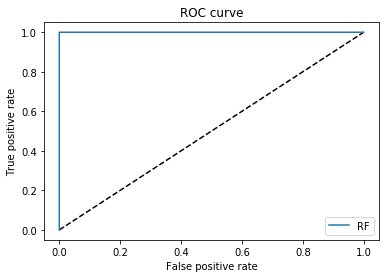

In [64]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Validation Metrics

              precision    recall  f1-score   support

           0       0.65      0.99      0.78      6413
           1       0.43      0.02      0.04      3535

    accuracy                           0.64      9948
   macro avg       0.54      0.50      0.41      9948
weighted avg       0.57      0.64      0.52      9948

Confusion Matrix
[[6327   86]
 [3470   65]]

Accuracy
0.6425412143144351


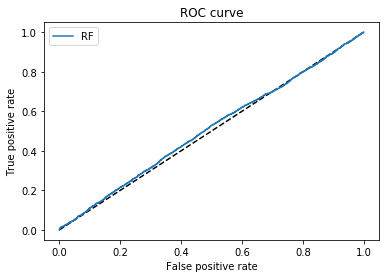

In [65]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [66]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
end = primary_forecast.index.get_loc('2017-12-29 21:03:37.018000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

KeyError: '2016-08-01 10:31:44.455000'

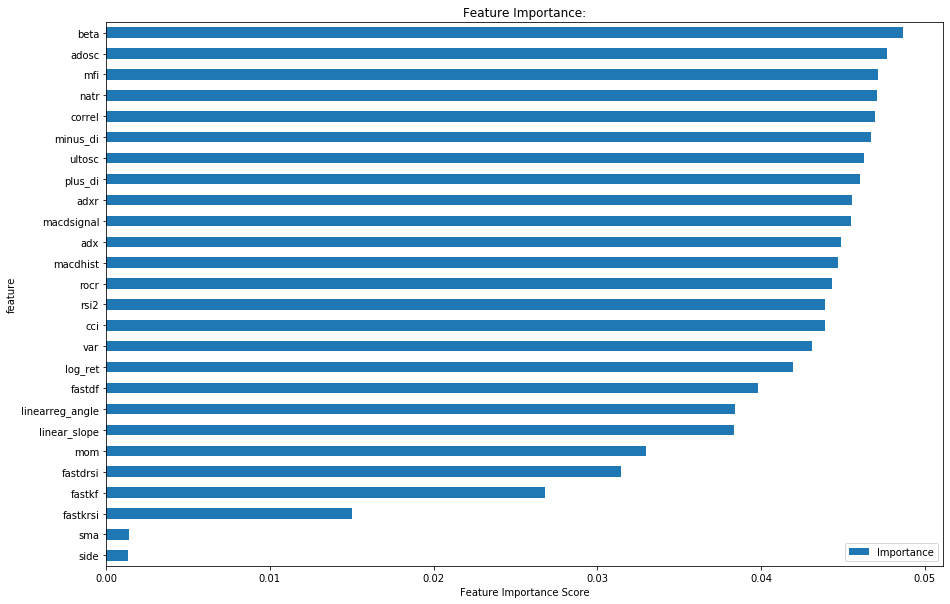

In [67]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 10)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

In [ ]:
import pyfolio as pf

In [ ]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [ ]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [ ]:


test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(primary_model_rets)
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)



In [ ]:
#save the data as a new 

In [ ]:
.to_pickle